활성화 함수 (activatino function)
- 입력 신호의 총합이 활성화를 일으키는지를 정하는 역할
- 계단함수  
if x > 0 -> 1 else 0
- 시그모이드 함수  
$h(x)=\frac{1}{1 + exp(-x)}$

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_func(func):
  x = np.arange(-5.0, 5.0, 0.1)
  y = func(x)
  
  plt.plot(x, y)
  plt.ylim(-0.5+min(y), 0.5+max(y))
  plt.show()
  

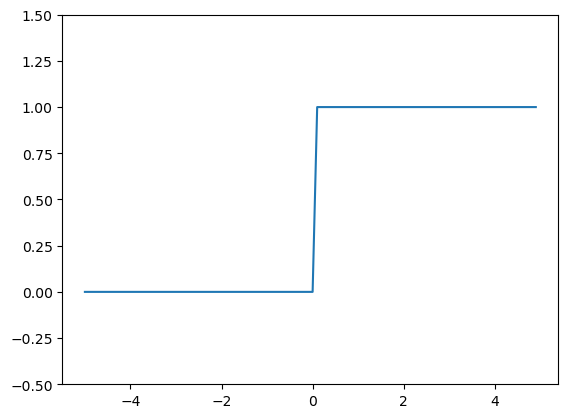

In [18]:
# 계단함수
def step_function(x):
  return np.array(x > 0, dtype=int)

plot_func(step_function)

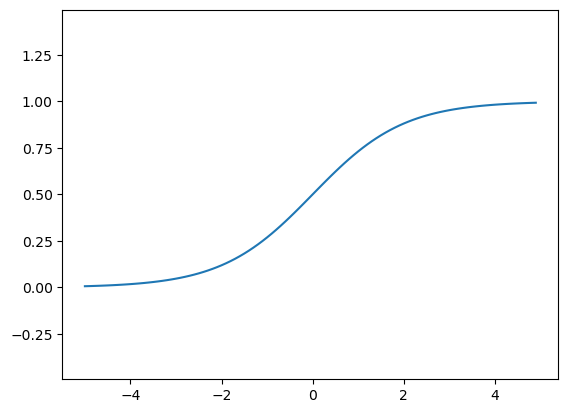

In [19]:
# 시그모이드 함수
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

plot_func(sigmoid)

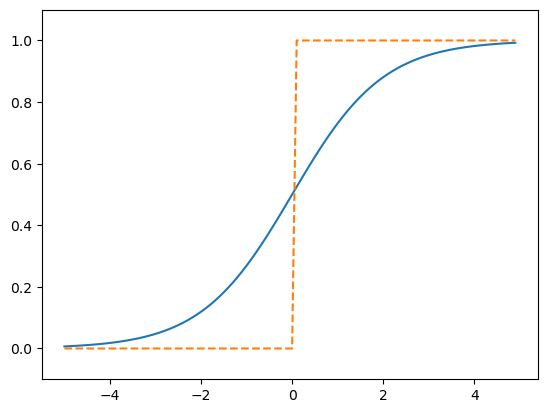

In [20]:
x = np.arange(-5.0, 5.0, 0.1)
y_sigmoid = sigmoid(x)
y_step = step_function(x)
  
plt.plot(x, y_sigmoid)
plt.plot(x, y_step, '--')
plt.ylim(-0.1, 1.1)
plt.show()
  

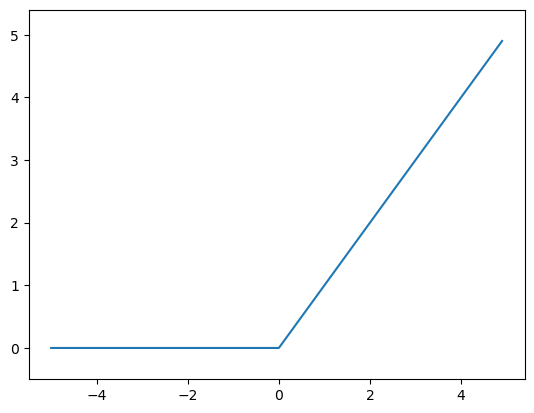

In [21]:
# ReLU 함수
def relu(x):
  return np.maximum(0, x)

plot_func(relu)

In [24]:
# 3층 신경망
X = np.array([1.0, 5.0])

W1 = np.array([[0.1, 0.3, 0.5], 
               [0.2, 0.4, 0.6]])
B1 = np.array([0.1, 0.2, 0.3])

print(W1.shape)
print(X.shape)
print(B1.shape)

A1 = np.dot(X, W1) + B1
print(A1.shape)

(2, 3)
(2,)
(3,)
(3,)


In [26]:
Z1 = sigmoid(A1)

print(A1)
print(Z1)

[1.2 2.5 3.8]
[0.76852478 0.92414182 0.97811873]


In [27]:
def identity_function(x):
  return x

In [33]:
def init_network():
  network = {}
  network['W1'] = np.array([[0.1, 0.3, 0.5],
                            [0.2, 0.4, 0.6]])
  network['b1'] = np.array([0.1, 0.2, 0.3])
  network['W2'] = np.array([[0.1, 0.4],
                            [0.2, 0.5],
                            [0.3, 0.6]])
  network['b2'] = np.array([0.1, 0.2])
  network['W3'] = np.array([[0.1, 0.3],
                            [0.2, 0.4]])
  network['b3'] = np.array([0.1, 0.2])
  
  return network
  
def forward(network, x):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  
  a1 = np.dot(x, W1) + b1
  z1 = sigmoid(a1)
  a2 = np.dot(z1, W2) + b2
  z2 = sigmoid(a2)
  a3 = np.dot(z2, W3) + b3
  y = identity_function(a3)
  
  return y

In [34]:
network = init_network()
x = np.array([1.0, 0.5])
y = forward(network, x)
print(y)

[0.31682708 0.69627909]


출력층을 바꿔서 회귀, 분류 문제 모두에 사용할 수 있다.
- 회귀 - 항등 함수
- 분류 - 소프트맥스 함수  
  - $y_k = \frac{exp(a_k)}{\sum_{i=1}^n exp(a_i)}$   
  - 0~1사이의 값을 리턴. 확률로 고려할 수 있음.   
  - 결과가 바뀌지 않기에 자원낭비를 줄이고자 추론 단계에서는 생략한다.

In [35]:
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  
  return y

소프트맥스 함수 구현시 주의점
- 오버플로 문제
- 지수함수는 쉽게 아주 큰 값을 내뱉고, 큰 값끼리 나눗셈을 하면 결과 수치가 불안정해짐.
- 표현할 수 있는 수의 범위를 넘어가는 문제    
$y_k = \frac{exp(a_k - C)}{\sum_{i=1}^n exp(a_i - C)}$   
 where c = max(a)

In [38]:
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a - c)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  
  return y

출력층의 뉴런 수는 풀려는 문제에 맞게 적절히 정해야한다.

순전파 ( forward propagation )

In [41]:
# MNIST dataset
import sys
sys.path.append("../modules") # go to parent dir
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [43]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [52]:
from PIL import Image

def img_show(img):
  pil_img = Image.fromarray(np.uint8(img))
  display(pil_img)

img = x_train[0]
label = t_train[0]
print(label)
print(img.shape)
img = img.reshape(28, 28)
print(img.shape)

img_show(img)

5
(784,)
(28, 28)


In [6]:
# MNIST dataset
import pickle
import sys
sys.path.append("../modules") # go to parent dir
from dataset.mnist import load_mnist
from common.activation_funcs import sigmoid, relu, softmax

# 신경망 추론 처리
def get_data(normalize=True):
  (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=normalize)
  return x_test, t_test

def init_network():
  with open("../../data/pickles/sample_weight.pkl", 'rb') as p:
    network = pickle.load(p)
    
  return network

def predict(network, x, use_relu=True):
  W1, W2, W3 = network['W1'], network['W2'], network['W3']
  b1, b2, b3 = network['b1'], network['b2'], network['b3']
  
  if use_relu: 
    h = relu
  else:
    h = sigmoid
  
  a1 = np.dot(x, W1) + b1
  z1 = h(a1)
  a2 = np.dot(z1, W2) + b2
  z2 = h(a2)
  a3 = np.dot(z2, W3) + b3
  y = softmax(a3)
  
  return y

In [9]:
import numpy as np

x, t = get_data(normalize=False)
network = init_network()

accuracy_cnt_relu = 0
for i in range(len(x)):
  y = predict(network, x[i], use_relu=True)
  p = np.argmax(y)
  if p == t[i]:
    accuracy_cnt_relu += 1
    
accuracy_cnt_sigmoid = 0
for i in range(len(x)):
  y = predict(network, x[i], use_relu=False)
  p = np.argmax(y)
  if p == t[i]:
    accuracy_cnt_sigmoid += 1
    
x, t = get_data(normalize=True)

accuracy_cnt_sigmoid_nomalize = 0
for i in range(len(x)):
  y = predict(network, x[i], use_relu=False)
  p = np.argmax(y)
  if p == t[i]:
    accuracy_cnt_sigmoid_nomalize += 1
    
print(f"Accuracy using relu : {accuracy_cnt_relu / len(x):.4f}")
print(f"Accuracy using sigmoid : {accuracy_cnt_sigmoid / len(x):.4f}")
print(f"Accuracy using sigmoid after normalize : {accuracy_cnt_sigmoid_nomalize / len(x):.4f}")

Accuracy using relu : 0.8286
Accuracy using sigmoid : 0.9207
Accuracy using sigmoid after normalize : 0.9352


배치처리는 컴퓨터로 계산할 때 큰 이점을 준다.   
이미지 1장당 처리 시간을 대폭 줄여줌  
- 수치 계산 라이브러리 대부분이 큰 배열을 효율적으로 처리할 수 있도록 고도로 최저고하되어 있기 때문
- 데이터전송이 병목으로 작용하는 경우가 자주 있음
- 배치처리를 함으로써 버스에 주는 부하를 줄인다는 것
- ( 느린 I/O를 통해 데이터를 읽는 횟수가 줄어, 빠른 CPU나 GPU로 순수 계산을 수행하는 비율이 높아짐)